In [ ]:
#to link google drive to collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from here on we are using pyspark for cleaing the data, so need to install pyspark first
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=40f421edf338130401ea61ab293737f1724dfe13e812cf507687188a0922e3fe
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
#to upload our Real_Fake_News_Dataset to collab workspace and covert into into an rdd
from pyspark import SparkContext
sc = SparkContext("local", "line_to_rdd")

file_path = '/content/drive/MyDrive/Real_Fake_News.txt'

newsdata_rdd_01 = sc.textFile(file_path)

print(newsdata_rdd_01.count())
print(newsdata_rdd_01.take(5))

26709
['{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret \'black code\' for minority shoppers", "is_sarcastic": 0}', '{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the \'roseanne\' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}', '{"article_link": "https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697", "headline": "mom starting to fear son\'s web series closest thing she will have to grandchild", "is_sarcastic": 1}', '{"article_link": "https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302", "headline": "boehner just wants wife to listen, not come up with alternative debt-reduction ideas", "is_sarcastic": 1}', '{"article_link": "https://www.huffingtonpost.com/entry/jk-rowling-w

In [ ]:
#START of cleaning data

#form the data of 26709 headlines we are taking 20000 headlines as for a good round number to work with
newsdata_rdd_02_data = newsdata_rdd_01.take(20000)
newsdata_rdd_02 = sc.parallelize(newsdata_rdd_02_data)
print(newsdata_rdd_02.count())

20000


In [ ]:
#splitting the elements of newsdata_rdd_02 at the delimiter --> ",
newsdata_rdd_03 = newsdata_rdd_02.map(lambda line: line.split('",'))
newsdata_rdd_03.take(2)

[['{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  ' "headline": "former versace store clerk sues over secret \'black code\' for minority shoppers',
  ' "is_sarcastic": 0}'],
 ['{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  ' "headline": "the \'roseanne\' revival catches up to our thorny political mood, for better and worse',
  ' "is_sarcastic": 0}']]

In [ ]:
#taking headlines first and removing all the unwanted tags and characters
headlines_rdd_01 = newsdata_rdd_03.map(lambda line: line[1])
headlines_rdd_01.take(2)

[' "headline": "former versace store clerk sues over secret \'black code\' for minority shoppers',
 ' "headline": "the \'roseanne\' revival catches up to our thorny political mood, for better and worse']

In [ ]:
#taking headlines first and removing all the unwanted tags and characters conti...
headlines_rdd_02 = headlines_rdd_01.map(lambda line: line.replace(' "headline": "', ''))
headlines_rdd_02.take(2)

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse"]

In [ ]:
#taking real or fake values/labels next and removing all the unwanted tags and characters
labels_rdd_01 = newsdata_rdd_03.map(lambda line: line[2])
labels_rdd_01.take(2)

[' "is_sarcastic": 0}', ' "is_sarcastic": 0}']

In [ ]:
#taking real or fake values/labels next and removing all the unwanted tags and characters conti...
labels_rdd_02 = labels_rdd_01.map(lambda line: line.replace('"is_sarcastic": ', '').replace('}', ''))
labels_rdd_02.take(5)

[' 0', ' 0', ' 1', ' 1', ' 0']

In [ ]:
#converting all these string values to integer 1s and 0s, now our labels are also ready
labels_rdd_03 = labels_rdd_02.map(lambda line: int(line.strip()))
labels_rdd_03.take(5)

[0, 0, 1, 1, 0]

In [ ]:
#lets take a quick count of the elements in each so that we know we didn't miss any during the cleaning process
print(headlines_rdd_02.count())
print(labels_rdd_03.count())

#END of data cleaning

20000
20000


In [ ]:
#the input into our model is an array and hence converting headlines and labels to an array
headlines_array = headlines_rdd_02.collect()
print(headlines_array)

labels_array = labels_rdd_03.collect()
print(labels_array)

["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild", 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'j.k. rowling wishes snape happy birthday in the most magical way', "advancing the world's women", 'the fascinating case for eating lab-grown meat', 'this ceo will send your kids to school, if you work for his company', 'top snake handler leaves sinking huckabee campaign', "friday's morning email: inside trump's presser for the ages", 'airline passengers tackle man who rushes cockpit in bomb threat', 'facebook reportedly working on healthcare features and apps', "north korea praises trump and urges us voters to reject 'dull hillary'", "actually, cnn's jeffrey lord has been 'indefensible' for a while", 'barcelona holds huge protest in support of refug

In [ ]:
#splitting out headlines and labels into two halves for training and testing purposes, lenght of each array is also checked
midpoint = len(labels_array) // 2

headlines_array_first_half = headlines_array[:midpoint]
headlines_array_second_half = headlines_array[midpoint:]

print("First half:", headlines_array_first_half)
print(len(headlines_array_first_half))
print("Second half:", headlines_array_second_half)
print(len(headlines_array_second_half))

labels_array_first_half = labels_array[:midpoint]
labels_array_second_half = labels_array[midpoint:]

print("First half:", labels_array_first_half)
print(len(labels_array_first_half))
print("Second half:", labels_array_second_half)
print(len(labels_array_first_half))

First half: ["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild", 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'j.k. rowling wishes snape happy birthday in the most magical way', "advancing the world's women", 'the fascinating case for eating lab-grown meat', 'this ceo will send your kids to school, if you work for his company', 'top snake handler leaves sinking huckabee campaign', "friday's morning email: inside trump's presser for the ages", 'airline passengers tackle man who rushes cockpit in bomb threat', 'facebook reportedly working on healthcare features and apps', "north korea praises trump and urges us voters to reject 'dull hillary'", "actually, cnn's jeffrey lord has been 'indefensible' for a while", 'barcelona holds huge protest in supp

In [ ]:
#the input to our model is a numpy array so converting to that
import numpy as np

train_headlines = np.array(headlines_array_first_half)
train_labels = np.array(labels_array_first_half)

test_headlines = np.array(headlines_array_second_half)
test_labels = np.array(labels_array_second_half)

In [ ]:
#to make the code rerunnable, I have to stop SparkContext each time after use
sc.stop()

In [ ]:
#now that data is clean and ready to be fed lets start with the training
#importing all libraries needed for the task
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [ ]:
#testing out the input data to tensor transformation of the first model, model_01: nnlm-en-dim50/2
model_01 = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer_01 = hub.KerasLayer(model_01, input_shape=[], dtype=tf.string, trainable=True)
hub_layer_01(train_headlines[:1]) #just checking what it has done with the first element of our headlines data

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.35428113, -0.06962717, -0.28452855, -0.24056415, -0.08724247,
         0.22789612, -0.00471761, -0.16518168,  0.3525679 , -0.129462  ,
         0.00913419, -0.03213856, -0.0038659 , -0.13561064,  0.01916916,
         0.20040445,  0.08339117, -0.01608667, -0.23538977,  0.02918525,
        -0.06515697,  0.17010875, -0.08127176, -0.03251407, -0.17315137,
         0.2274271 , -0.18697484, -0.00357309, -0.18075478,  0.26707605,
        -0.05526528, -0.17674883,  0.02437577, -0.1428565 ,  0.0801765 ,
        -0.11517531, -0.11693425,  0.21679147, -0.01290909,  0.28700933,
         0.21956685, -0.19940975, -0.08583395,  0.22576377,  0.18363975,
        -0.08440258,  0.18660983,  0.12644708,  0.12409031,  0.13184376]],
      dtype=float32)>

In [ ]:
#using this model_01 to convert all our elements, and adding needed configurations and layers
model_01 = tf.keras.Sequential()
model_01.add(hub_layer_01)
model_01.add(tf.keras.layers.Dense(16, activation='relu')) #16, 32, 64
model_01.add(tf.keras.layers.Dense(1))

model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#configuring our loss function and optimizer for model_01, after we compile this model here we are ready to fit our data into it
model_01.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
#create a validation set by setting apart 5000 elements from the original training data of 10000 elements
validation_headlines = train_headlines[:5000]
partial_train_headlines = train_headlines[5000:]

validation_labels = train_labels[:5000]
partial_train_labels = train_labels[5000:]

In [ ]:
#and at last training model_01 with our data
import time
start_time = time.time()  #record the start time

history_01 = model_01.fit(partial_train_headlines,
                    partial_train_labels,
                    epochs=15,
                    batch_size=512,
                    validation_data=(validation_headlines, validation_labels),
                    verbose=1)

end_time = time.time()  #record the end time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/15
10/10 [==============================] - 27s 2s/step - loss: 0.7117 - accuracy: 0.4686 - val_loss: 0.6999 - val_accuracy: 0.4908
Epoch 2/15
10/10 [==============================] - 21s 2s/step - loss: 0.6784 - accuracy: 0.5714 - val_loss: 0.6799 - val_accuracy: 0.5858
Epoch 3/15
10/10 [==============================] - 18s 2s/step - loss: 0.6499 - accuracy: 0.7128 - val_loss: 0.6615 - val_accuracy: 0.6542
Epoch 4/15
10/10 [==============================] - 18s 2s/step - loss: 0.6189 - accuracy: 0.8030 - val_loss: 0.6408 - val_accuracy: 0.6974
Epoch 5/15
10/10 [==============================] - 21s 2s/step - loss: 0.5817 - accuracy: 0.8478 - val_loss: 0.6164 - val_accuracy: 0.7266
Epoch 6/15
10/10 [==============================] - 20s 2s/step - loss: 0.5374 - accuracy: 0.8788 - val_loss: 0.5877 - val_accuracy: 0.7514
Epoch 7/15
10/10 [==============================] - 23s 2s/step - loss: 0.4855 - accuracy: 0.9024 - val_loss: 0.5560 - val_accuracy: 0.7670
Epoch 8/15
10/10 [==

In [ ]:
#now that training is complete we can check the accuracy of our model with our test dataset we kept apart earlier
results_01 = model_01.evaluate(test_headlines, test_labels)

print(results_01)

313/313 [==============================] - 71s 227ms/step - loss: 0.4142 - accuracy: 0.8141
[0.4141676723957062, 0.8141000270843506]


In [ ]:
#next a couple of steps to import information obtained during our training, so as to pass it as data for a plotting software/function
results_pred_01 = model_01.predict(test_headlines)
classes_x_01 = np.argmax(results_pred_01 ,axis=1)

history_dict_01 = history_01.history
history_dict_01.keys()

313/313 [==============================] - 72s 231ms/step


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

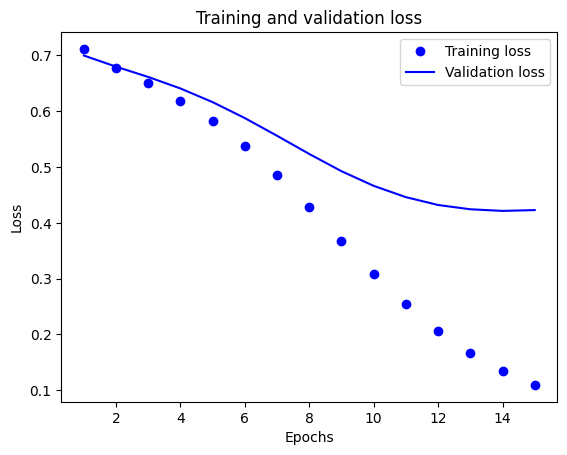

In [ ]:
#to visualize epoch vs loss
acc_01 = history_dict_01['accuracy']
val_acc_01 = history_dict_01['val_accuracy']
loss_01 = history_dict_01['loss']
val_loss_01 = history_dict_01['val_loss']

epochs_01 = range(1, len(acc_01) + 1)

# "bo" is for "blue dot"
plt.plot(epochs_01, loss_01, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_01, val_loss_01, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

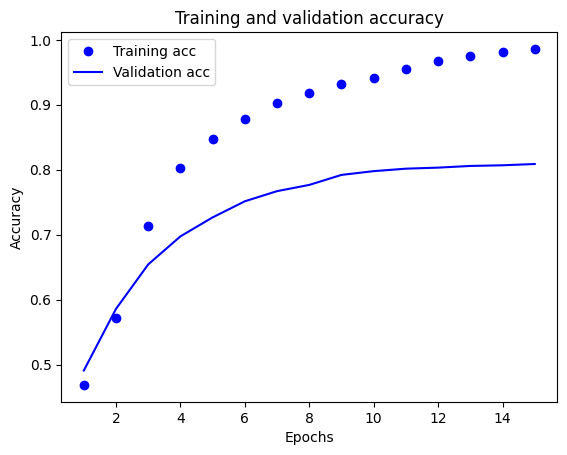

In [ ]:
#to visualize epoch vs accuracy
plt.clf()   # clear figure

plt.plot(epochs_01, acc_01, 'bo', label='Training acc')
plt.plot(epochs_01, val_acc_01, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

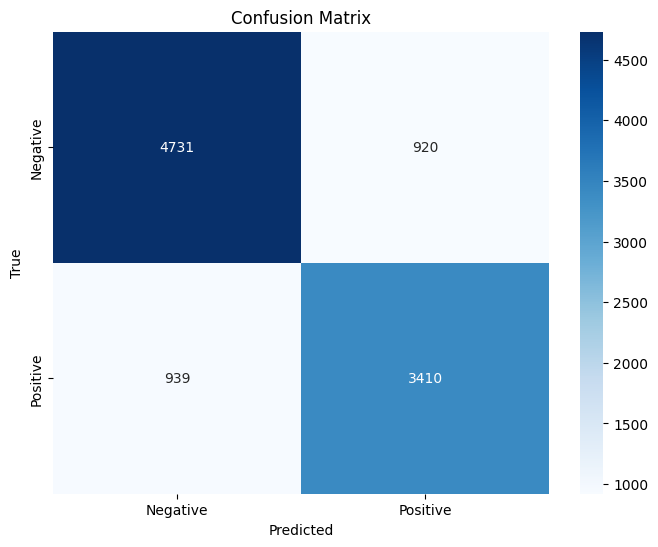

In [ ]:
#to plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predicted probabilities to binary predictions (0 or 1)
predicted_labels_01 = (results_pred_01 > 0).astype(int)

# Generate confusion matrix
conf_matrix_01 = confusion_matrix(test_labels, predicted_labels_01)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_01, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Printing out predicted correct and predicted wrong for our report
tn, fp, fn, tp = conf_matrix_01.ravel()

print("Predicted Correct (True Negatives + True Positives):", tn + tp)
print("Predicted Wrong (False Negatives + False Positives):", fn + fp)

Predicted Correct (True Negatives + True Positives): 8141
Predicted Wrong (False Negatives + False Positives): 1859


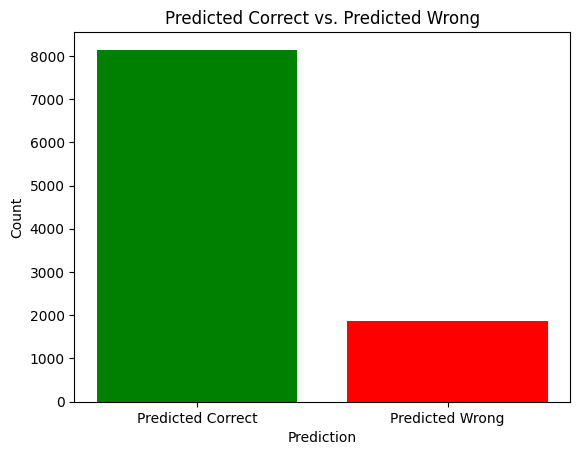

In [ ]:
#ploting the above on a bar chart for easy understanding
import matplotlib.pyplot as plt

labels = ['Predicted Correct', 'Predicted Wrong']
counts = [tn + tp, fn + fp]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Predicted Correct vs. Predicted Wrong')
plt.show()

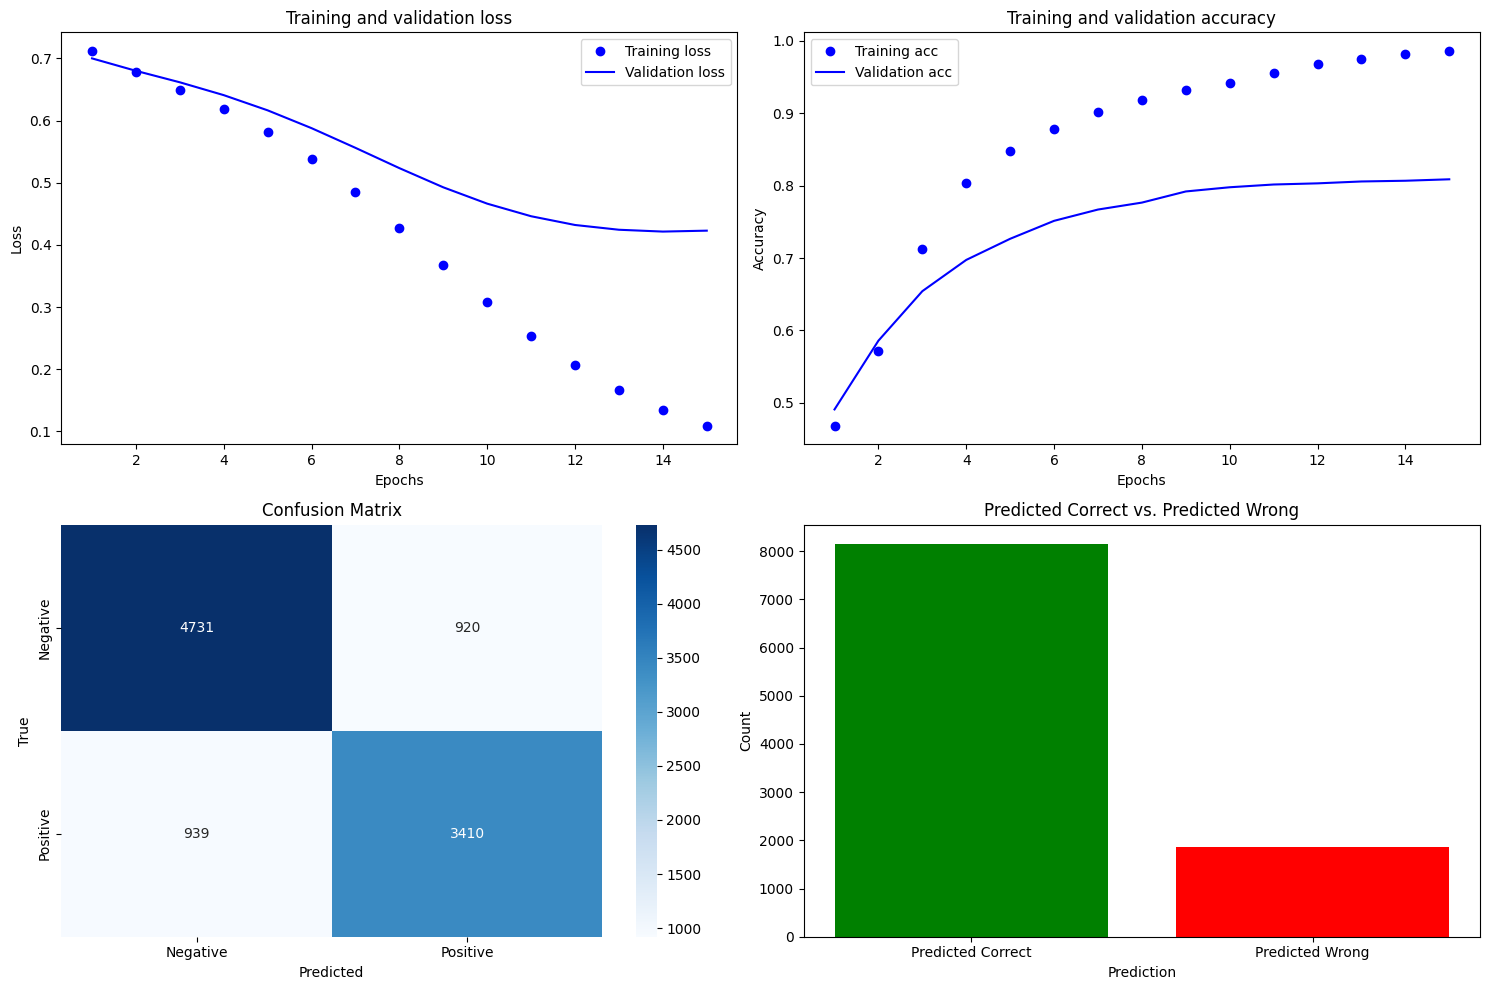

In [ ]:
#printing consolidated list of all resultant graphs in one image out
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and validation loss
axes[0, 0].plot(epochs_01, loss_01, 'bo', label='Training loss')
axes[0, 0].plot(epochs_01, val_loss_01, 'b', label='Validation loss')
axes[0, 0].set_title('Training and validation loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot 2: Training and validation accuracy
axes[0, 1].plot(epochs_01, acc_01, 'bo', label='Training acc')
axes[0, 1].plot(epochs_01, val_acc_01, 'b', label='Validation acc')
axes[0, 1].set_title('Training and validation accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot 3: Confusion matrix heatmap
sns.heatmap(conf_matrix_01, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')
axes[1, 0].set_title('Confusion Matrix')

# Plot 4: Bar chart for predicted correct vs. predicted wrong
labels = ['Predicted Correct', 'Predicted Wrong']
counts = [tn + tp, fn + fp]
axes[1, 1].bar(labels, counts, color=['green', 'red'])
axes[1, 1].set_xlabel('Prediction')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Predicted Correct vs. Predicted Wrong')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
#lets try the next model,
#testing out the input data to tensor transformation of the second model
model_02 = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer_02 = hub.KerasLayer(model_02, input_shape=[], dtype=tf.string, trainable=True)
hub_layer_02(train_headlines[:1]) #just checking what it has done with the first element of our headlines data

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.18648456, -0.10235878, -0.23920077, -0.3046748 , -0.0995851 ,
         0.11678435,  0.04764381, -0.22777568,  0.26038513, -0.14586613,
         0.02899157,  0.26377165, -0.15194152, -0.0987225 ,  0.01461467,
         0.15983224,  0.24739209,  0.01833926, -0.22551   , -0.20817438,
        -0.18380417,  0.22163527,  0.06602883, -0.10409688, -0.16720611,
         0.2335171 , -0.12550792, -0.21982785, -0.18371485,  0.2630606 ,
         0.00775021, -0.21596259,  0.05101054, -0.20371644,  0.04979607,
        -0.27720284, -0.06110788,  0.36941826, -0.09014513,  0.12382214,
         0.21744211, -0.15863927, -0.08538403,  0.27016422,  0.10952333,
        -0.09925222,  0.21023883,  0.17673515,  0.20356295,  0.0521037 ]],
      dtype=float32)>

In [ ]:
#using this model_02 to convert all our elements, and adding needed configurations and layers
model_02 = tf.keras.Sequential()
model_02.add(hub_layer_02)
model_02.add(tf.keras.layers.Dense(16, activation='relu'))
model_02.add(tf.keras.layers.Dense(1))

model_02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#configuring our loss function and optimizer for model_02, after we compile this model here we are ready to fit our data into it
model_02.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
#and at last training model_02 with our data
import time
start_time = time.time()  #record the start time

history_02 = model_02.fit(partial_train_headlines,
                    partial_train_labels,
                    epochs=15,
                    batch_size=512,
                    validation_data=(validation_headlines, validation_labels),
                    verbose=1)

end_time = time.time()  #record the end time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/15
10/10 [==============================] - 21s 2s/step - loss: 0.7001 - accuracy: 0.4798 - val_loss: 0.6854 - val_accuracy: 0.5554
Epoch 2/15
10/10 [==============================] - 19s 2s/step - loss: 0.6677 - accuracy: 0.6476 - val_loss: 0.6656 - val_accuracy: 0.6530
Epoch 3/15
10/10 [==============================] - 20s 2s/step - loss: 0.6377 - accuracy: 0.7466 - val_loss: 0.6446 - val_accuracy: 0.7050
Epoch 4/15
10/10 [==============================] - 19s 2s/step - loss: 0.6032 - accuracy: 0.8066 - val_loss: 0.6194 - val_accuracy: 0.7364
Epoch 5/15
10/10 [==============================] - 21s 2s/step - loss: 0.5607 - accuracy: 0.8488 - val_loss: 0.5888 - val_accuracy: 0.7612
Epoch 6/15
10/10 [==============================] - 21s 2s/step - loss: 0.5093 - accuracy: 0.8762 - val_loss: 0.5534 - val_accuracy: 0.7790
Epoch 7/15
10/10 [==============================] - 23s 2s/step - loss: 0.4495 - accuracy: 0.8958 - val_loss: 0.5159 - val_accuracy: 0.7888
Epoch 8/15
10/10 [==

In [ ]:
#now that training is complete we can check the accuracy of our model with our test dataset we kept apart earlier
results_02 = model_02.evaluate(test_headlines, test_labels)

print(results_02)

313/313 [==============================] - 78s 249ms/step - loss: 0.4025 - accuracy: 0.8218
[0.40250587463378906, 0.8217999935150146]


In [ ]:
#next a couple of steps to import information obtained during our training, so as to pass it as data for a plotting software/function
results_pred_02 = model_02.predict(test_headlines)
classes_x_02 = np.argmax(results_pred_02 ,axis=1)

history_dict_02 = history_02.history
history_dict_02.keys()

313/313 [==============================] - 67s 215ms/step


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

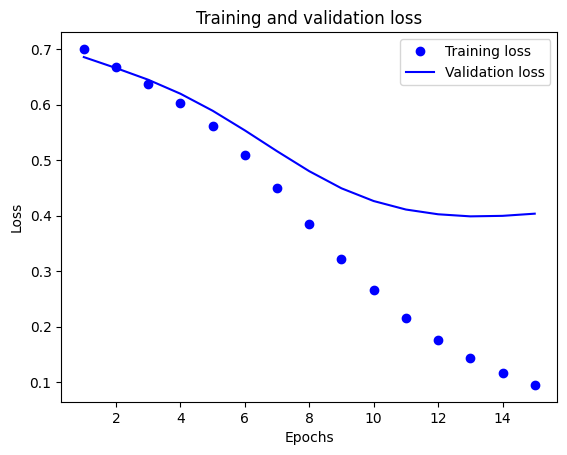

In [ ]:
#to visualize epoch vs loss
acc_02 = history_dict_02['accuracy']
val_acc_02 = history_dict_02['val_accuracy']
loss_02 = history_dict_02['loss']
val_loss_02 = history_dict_02['val_loss']

epochs_02 = range(1, len(acc_02) + 1)

# "bo" is for "blue dot"
plt.plot(epochs_02, loss_02, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_02, val_loss_02, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

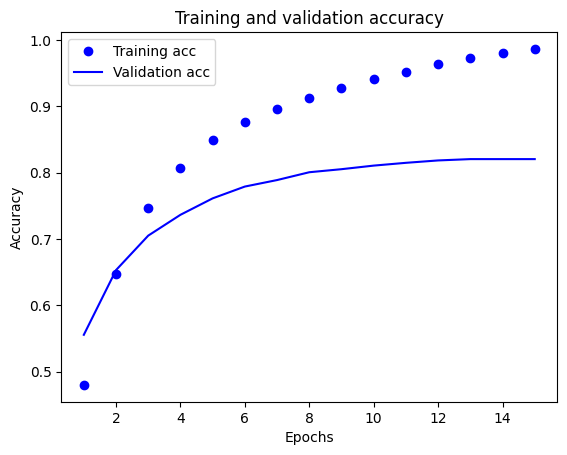

In [ ]:
#to visualize epoch vs accuracy
plt.clf()   # clear figure

plt.plot(epochs_02, acc_02, 'bo', label='Training acc')
plt.plot(epochs_02, val_acc_02, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

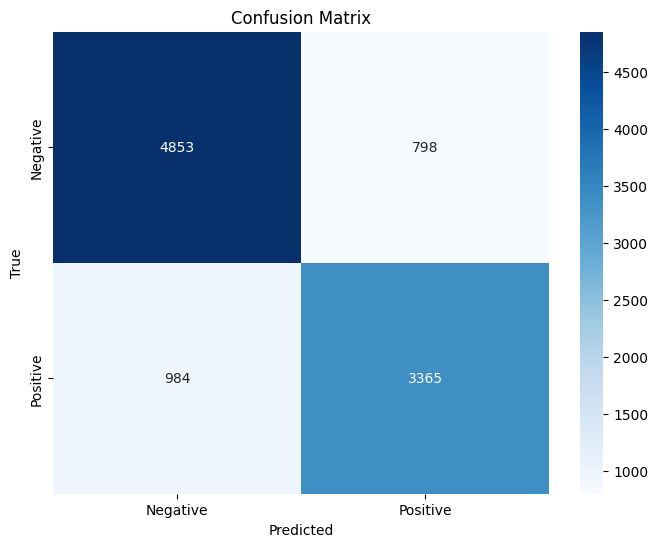

In [ ]:
#to plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predicted probabilities to binary predictions (0 or 1)
predicted_labels_02 = (results_pred_02 > 0).astype(int)

# Generate confusion matrix
conf_matrix_02 = confusion_matrix(test_labels, predicted_labels_02)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_02, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Printing out predicted correct and predicted wrong for our report
tn, fp, fn, tp = conf_matrix_02.ravel()

print("Predicted Correct (True Negatives + True Positives):", tn + tp)
print("Predicted Wrong (False Negatives + False Positives):", fn + fp)

Predicted Correct (True Negatives + True Positives): 8218
Predicted Wrong (False Negatives + False Positives): 1782


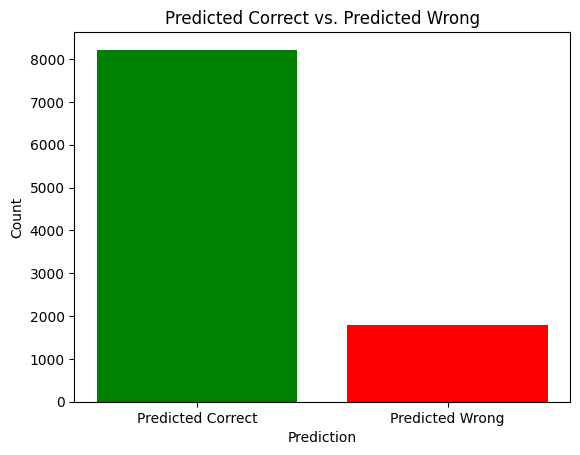

In [ ]:
#ploting the above on a bar chart for easy understanding
import matplotlib.pyplot as plt

labels = ['Predicted Correct', 'Predicted Wrong']
counts = [tn + tp, fn + fp]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Predicted Correct vs. Predicted Wrong')
plt.show()

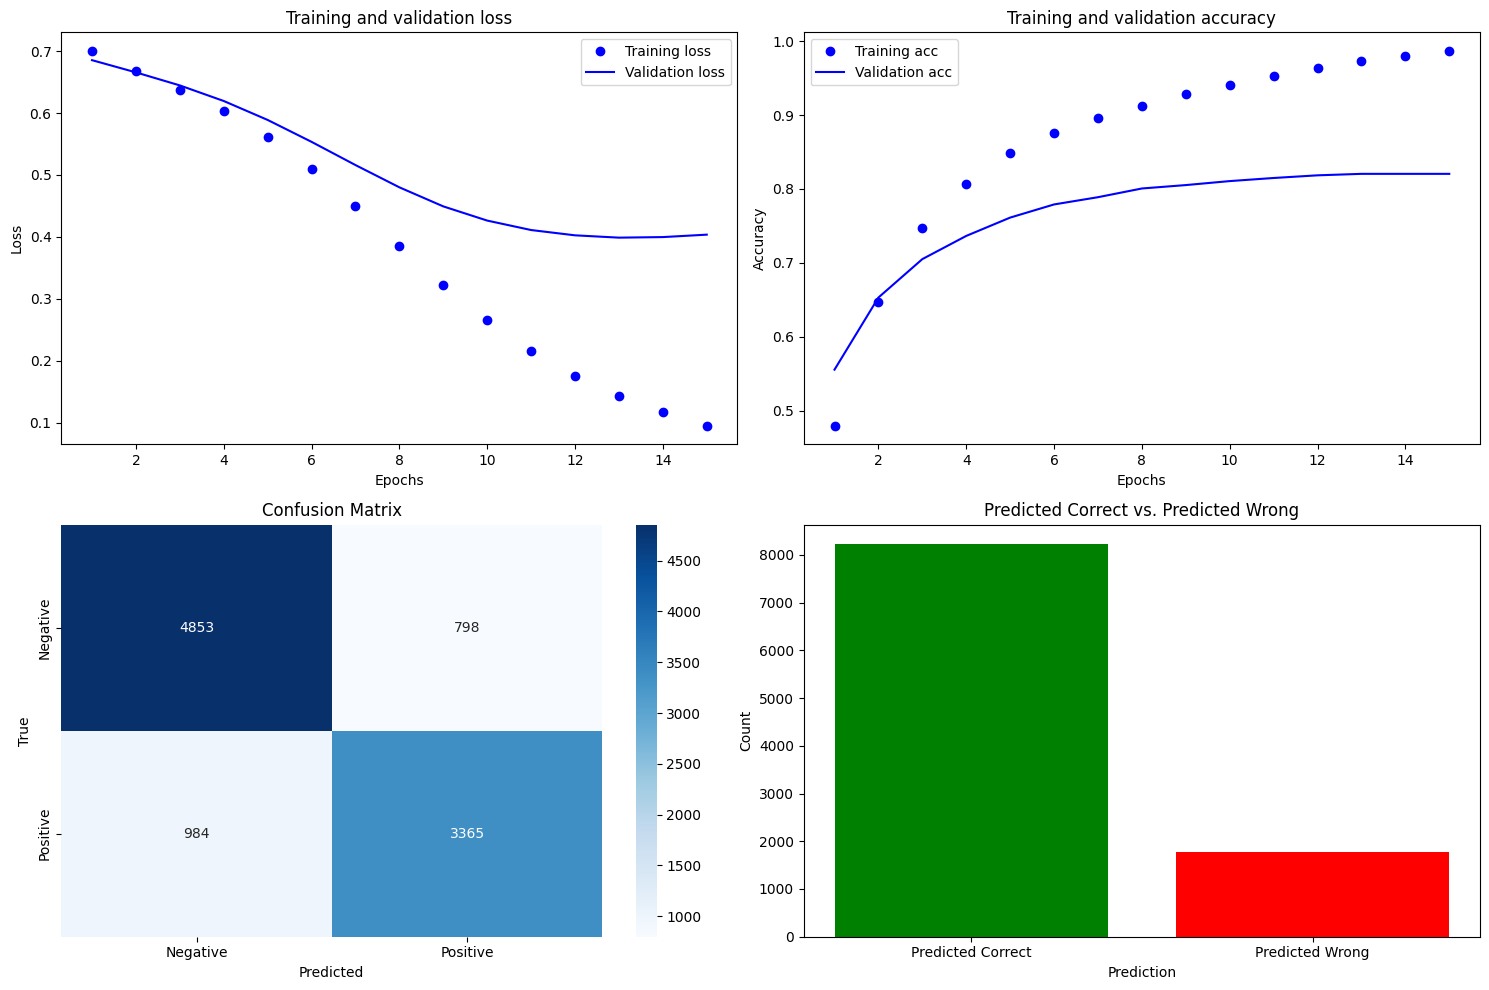

In [ ]:
#printing consolidated list of all resultant graphs in one image out
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and validation loss
axes[0, 0].plot(epochs_02, loss_02, 'bo', label='Training loss')
axes[0, 0].plot(epochs_02, val_loss_02, 'b', label='Validation loss')
axes[0, 0].set_title('Training and validation loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot 2: Training and validation accuracy
axes[0, 1].plot(epochs_02, acc_02, 'bo', label='Training acc')
axes[0, 1].plot(epochs_02, val_acc_02, 'b', label='Validation acc')
axes[0, 1].set_title('Training and validation accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot 3: Confusion matrix heatmap
sns.heatmap(conf_matrix_02, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')
axes[1, 0].set_title('Confusion Matrix')

# Plot 4: Bar chart for predicted correct vs. predicted wrong
labels = ['Predicted Correct', 'Predicted Wrong']
counts = [tn + tp, fn + fp]
axes[1, 1].bar(labels, counts, color=['green', 'red'])
axes[1, 1].set_xlabel('Prediction')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Predicted Correct vs. Predicted Wrong')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
#lets try the next model,  model_03: nnlm-en-dim128-with-normalization/2
#testing out the input data to tensor transformation of the second model
model_03 = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer_03 = hub.KerasLayer(model_03, input_shape=[], dtype=tf.string, trainable=True)
hub_layer_03(train_headlines[:1]) #just checking what it has done with the first element of our headlines data

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.15923211,  0.24571228,  0.22630689, -0.22370502,  0.00429583,
         0.16496871, -0.09036624,  0.14825173, -0.09558138,  0.10549317,
        -0.09033064,  0.02226545, -0.06714258,  0.00173584,  0.08717989,
        -0.11955194, -0.22934823, -0.10569704, -0.09431402,  0.06301794,
        -0.2060757 ,  0.20009485, -0.24306248, -0.06110588,  0.01142561,
        -0.1895696 ,  0.06594652, -0.11791465, -0.05922721,  0.02954152,
         0.0176305 ,  0.01352224, -0.05981631,  0.07146528,  0.10379829,
         0.02519797, -0.00708102, -0.07630339,  0.12006259, -0.0453946 ,
        -0.11771474, -0.02730765, -0.02161883,  0.03247225, -0.05249989,
        -0.18873465,  0.00578884, -0.01046251,  0.08496444, -0.13768055,
        -0.06076519, -0.11916804,  0.09516779,  0.03508179, -0.061901  ,
         0.03187613,  0.09521872, -0.06926113,  0.00217862,  0.03008761,
        -0.10758062,  0.12566742,  0.05312664, -0.12523171,  0.08149192,
 

In [ ]:
#using this model_03 to convert all our elements, and adding needed configurations and layers
model_03 = tf.keras.Sequential()
model_03.add(hub_layer_03)
model_03.add(tf.keras.layers.Dense(16, activation='relu'))
model_03.add(tf.keras.layers.Dense(1))

model_03.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124644769 (475.48 MB)
Trainable params: 124644769 (475.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#configuring our loss function and optimizer for model_03, after we compile this model here we are ready to fit our data into it
model_03.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [ ]:
#and at last training model_03 with our data
import time
start_time = time.time()  #record the start time

history_03 = model_03.fit(partial_train_headlines,
                    partial_train_labels,
                    epochs=15,
                    batch_size=512,
                    validation_data=(validation_headlines, validation_labels),
                    verbose=1)

end_time = time.time()  #record the end time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/15
10/10 [==============================] - 51s 5s/step - loss: 0.6811 - accuracy: 0.5956 - val_loss: 0.6653 - val_accuracy: 0.6654
Epoch 2/15
10/10 [==============================] - 46s 5s/step - loss: 0.6360 - accuracy: 0.7656 - val_loss: 0.6329 - val_accuracy: 0.7202
Epoch 3/15
10/10 [==============================] - 46s 4s/step - loss: 0.5817 - accuracy: 0.8314 - val_loss: 0.5913 - val_accuracy: 0.7548
Epoch 4/15
10/10 [==============================] - 55s 6s/step - loss: 0.5119 - accuracy: 0.8706 - val_loss: 0.5415 - val_accuracy: 0.7798
Epoch 5/15
10/10 [==============================] - 53s 5s/step - loss: 0.4289 - accuracy: 0.9038 - val_loss: 0.4893 - val_accuracy: 0.8028
Epoch 6/15
10/10 [==============================] - 53s 5s/step - loss: 0.3421 - accuracy: 0.9236 - val_loss: 0.4452 - val_accuracy: 0.8120
Epoch 7/15
10/10 [==============================] - 51s 5s/step - loss: 0.2639 - accuracy: 0.9424 - val_loss: 0.4136 - val_accuracy: 0.8206
Epoch 8/15
10/10 [==

In [ ]:
#now that training is complete we can check the accuracy of our model with our test dataset we kept apart earlier
results_03 = model_03.evaluate(test_headlines, test_labels)

print(results_03)

313/313 [==============================] - 174s 554ms/step - loss: 0.4409 - accuracy: 0.8157
[0.4408756494522095, 0.8156999945640564]


In [ ]:
#next a couple of steps to import information obtained during our training, so as to pass it as data for a plotting software/function
results_pred_03 = model_03.predict(test_headlines)
classes_x_03 = np.argmax(results_pred_03 ,axis=1)

history_dict_03 = history_03.history
history_dict_03.keys()

313/313 [==============================] - 186s 596ms/step


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

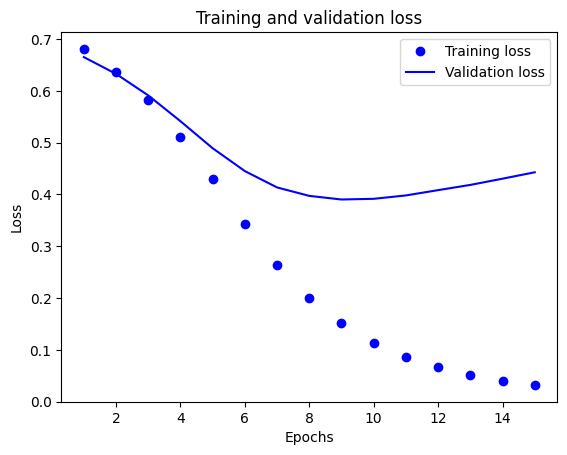

In [ ]:
#to visualize epoch vs loss
acc_03 = history_dict_03['accuracy']
val_acc_03 = history_dict_03['val_accuracy']
loss_03 = history_dict_03['loss']
val_loss_03 = history_dict_03['val_loss']

epochs_03 = range(1, len(acc_03) + 1)

# "bo" is for "blue dot"
plt.plot(epochs_03, loss_03, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_03, val_loss_03, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

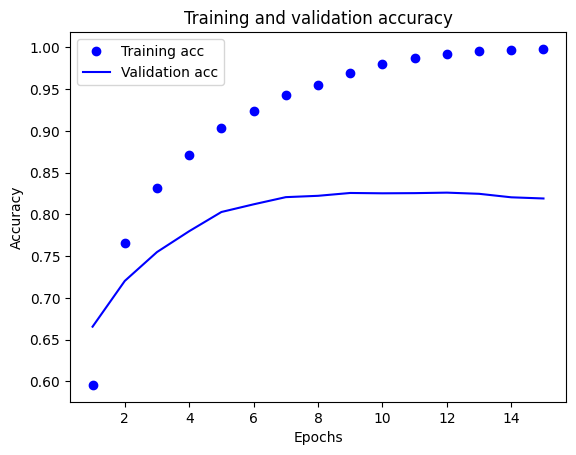

In [ ]:
#to visualize epoch vs accuracy
plt.clf()   # clear figure

plt.plot(epochs_03, acc_03, 'bo', label='Training acc')
plt.plot(epochs_03, val_acc_03, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

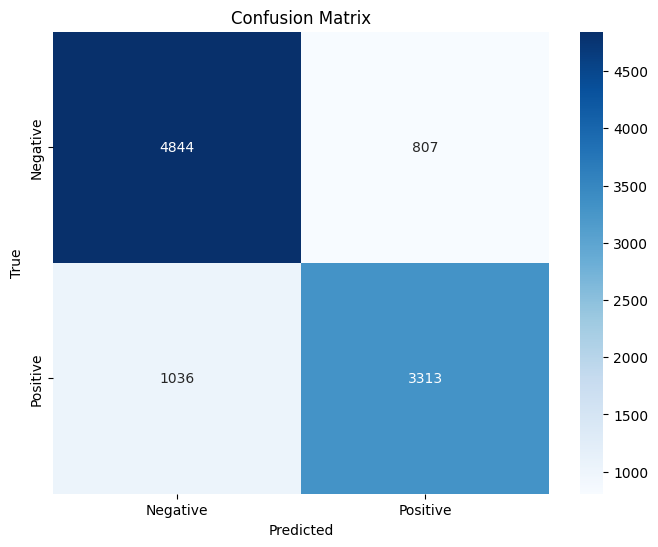

In [ ]:
#to plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predicted probabilities to binary predictions (0 or 1)
predicted_labels_03 = (results_pred_03 > 0).astype(int)

# Generate confusion matrix
conf_matrix_03 = confusion_matrix(test_labels, predicted_labels_03)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_03, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Printing out predicted correct and predicted wrong for our report
tn, fp, fn, tp = conf_matrix_03.ravel()

print("Predicted Correct (True Negatives + True Positives):", tn + tp)
print("Predicted Wrong (False Negatives + False Positives):", fn + fp)

Predicted Correct (True Negatives + True Positives): 8157
Predicted Wrong (False Negatives + False Positives): 1843


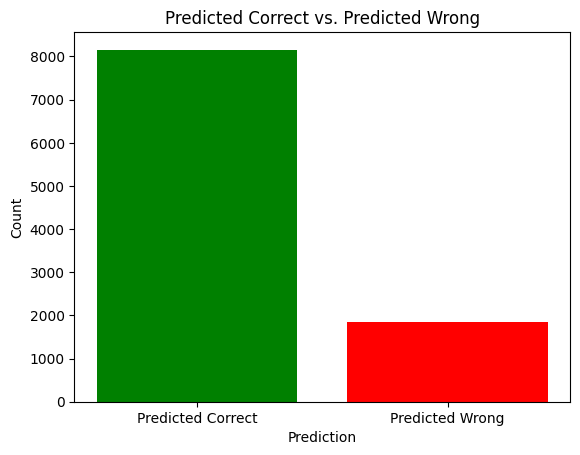

In [ ]:
#ploting the above on a bar chart for easy understanding
import matplotlib.pyplot as plt

labels = ['Predicted Correct', 'Predicted Wrong']
counts = [tn + tp, fn + fp]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Predicted Correct vs. Predicted Wrong')
plt.show()

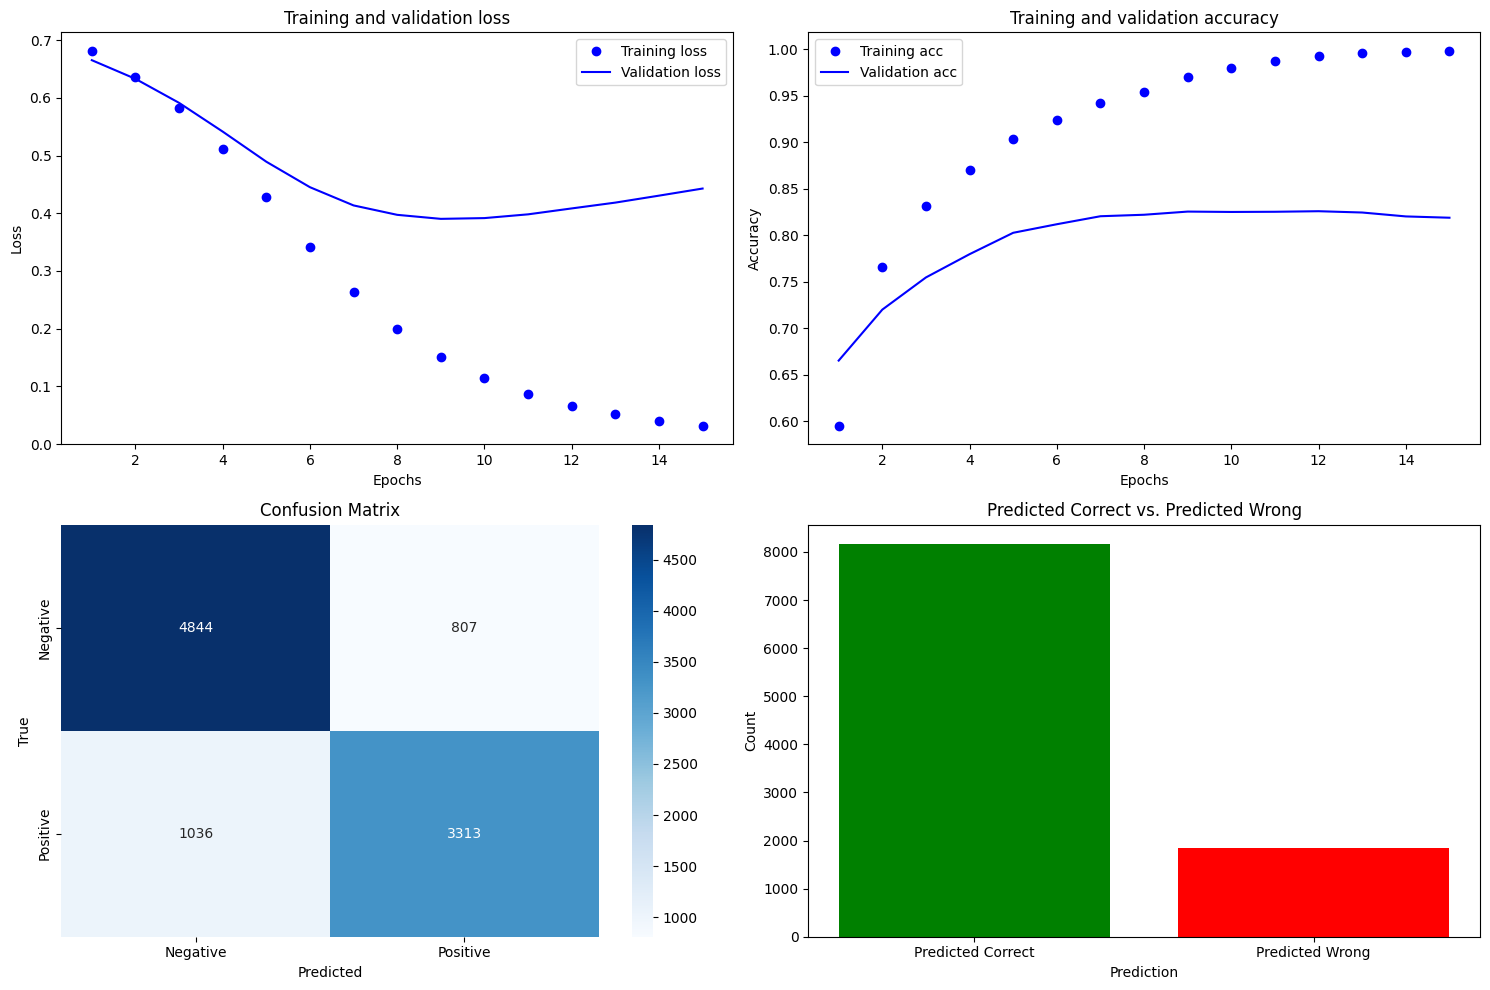

In [ ]:
#printing consolidated list of all resultant graphs in one image out
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and validation loss
axes[0, 0].plot(epochs_03, loss_03, 'bo', label='Training loss')
axes[0, 0].plot(epochs_03, val_loss_03, 'b', label='Validation loss')
axes[0, 0].set_title('Training and validation loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot 2: Training and validation accuracy
axes[0, 1].plot(epochs_03, acc_03, 'bo', label='Training acc')
axes[0, 1].plot(epochs_03, val_acc_03, 'b', label='Validation acc')
axes[0, 1].set_title('Training and validation accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Plot 3: Confusion matrix heatmap
sns.heatmap(conf_matrix_03, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')
axes[1, 0].set_title('Confusion Matrix')

# Plot 4: Bar chart for predicted correct vs. predicted wrong
labels = ['Predicted Correct', 'Predicted Wrong']
counts = [tn + tp, fn + fp]
axes[1, 1].bar(labels, counts, color=['green', 'red'])
axes[1, 1].set_xlabel('Prediction')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Predicted Correct vs. Predicted Wrong')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
#END ~Written and Compiled by Akash Siva Kumar